In [1]:
# Set up sys.path and import needed packages.
import _preamble

import numpy as np
import matplotlib.pyplot as plt

from pmte import estimation, tapers, util
import helpers

In [2]:
# Set basic parameters.
N = 128  # Size of images
W = 1 / 8  # Bandwidth
R = N / 3  # Radius of disk

# Initialize PRNG.
rng = np.random.default_rng(0)

In [3]:
# Define masks (square and complement of disk) and target window.
mask_square = helpers.square_mask(N, R)
mask_compl = ~helpers.disk_mask(N, R)

rho_target = helpers.target_spectral_window(N, W, shifted=True)

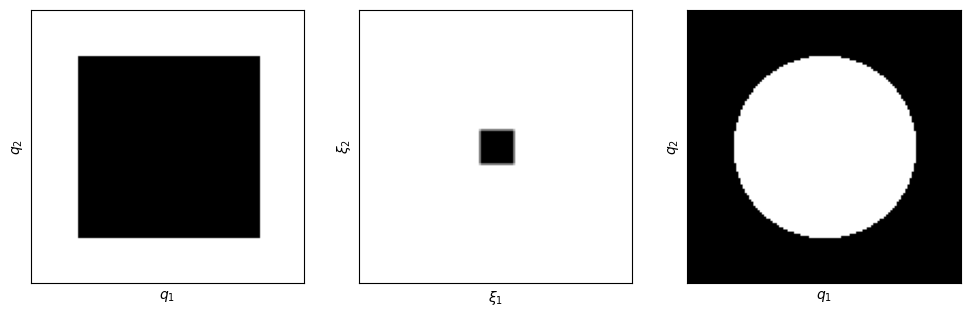

In [4]:
# Plot Figure 5 in paper.
plt.figure(figsize=(12, 6))

plt.subplot(131)
helpers.plot_grayscale_image(mask_square, diverging=False)

plt.subplot(132)
helpers.plot_grayscale_image(rho_target, diverging=False, axis="\\xi")

plt.subplot(133)
helpers.plot_grayscale_image(mask_compl, diverging=False)

plt.show(block=False)

In [5]:
# Generate tensor (Slepian) tapers over the centered square of size 2R×2R
# defined by mask_square. This is done by first creating the tapers over the
# square and then padding to the desired size.
N_tensor = int(np.floor(2 * R))

h_slepian_square = tapers.tensor_tapers((N_tensor, N_tensor), W)

# Amount to pad for left (top) and right (bottom).
pad = (int(np.ceil((N - N_tensor) / 2)), int(np.floor((N - N_tensor) / 2)))

# No padding along the zeroth dimension, since this corresponds to the
# index of the tapers.
h_slepian_square = np.pad(h_slepian_square, ((0, 0),) + (pad,) * 2)

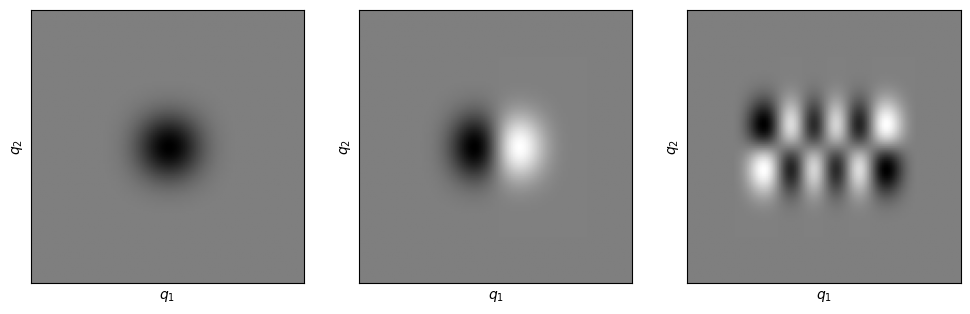

In [6]:
# Plot the top row of Figure 6 in the paper.
plt.figure(figsize=(12, 6))

plt.subplot(131)
helpers.plot_grayscale_image(h_slepian_square[0])

plt.subplot(132)
helpers.plot_grayscale_image(h_slepian_square[1])

plt.subplot(133)
helpers.plot_grayscale_image(h_slepian_square[16])

plt.show(block=False)

In [7]:
# Generate proxy tapers for the centered square. To make sure we obtain the
# same number of tapers as for the tensor case, fix the number of tapers K
# manually.
K = h_slepian_square.shape[0]
h_proxy_square = tapers.proxy_tapers(mask_square, W, K=K, rng=rng)

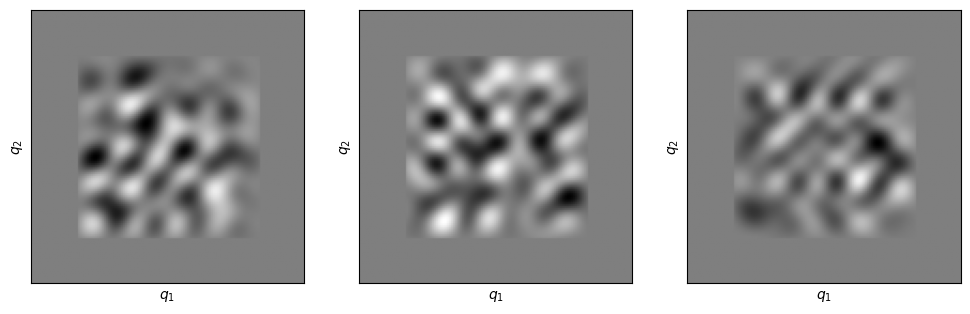

In [8]:
# Plot the middle row of Figure 6 in the paper.
plt.figure(figsize=(12, 6))

plt.subplot(131)
helpers.plot_grayscale_image(h_proxy_square[0])

plt.subplot(132)
helpers.plot_grayscale_image(h_proxy_square[1])

plt.subplot(133)
helpers.plot_grayscale_image(h_proxy_square[16])

plt.show(block=False)

In [9]:
# Generate proxy tapers for the complement of the disk.
h_proxy_compl = tapers.proxy_tapers(mask_compl, W, rng=rng)

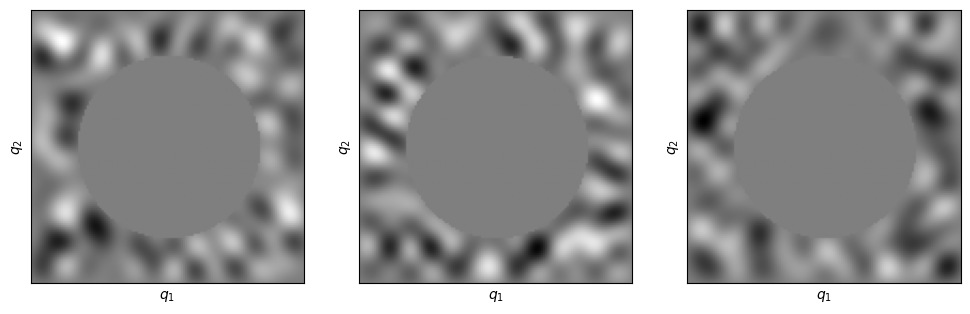

In [10]:
# Plot the bottom row of Figure 6 in the paper.
plt.figure(figsize=(12, 6))

plt.subplot(131)
helpers.plot_grayscale_image(h_proxy_compl[0])

plt.subplot(132)
helpers.plot_grayscale_image(h_proxy_compl[1])

plt.subplot(133)
helpers.plot_grayscale_image(h_proxy_compl[16])

plt.show(block=False)

In [11]:
# Calculate accumulated spectral windows for each set of tapers. These
# correspond to eq. (4.1) in the paper.
rho_slepian_square = tapers.spectral_window(h_slepian_square, shifted=True)
rho_proxy_square = tapers.spectral_window(h_proxy_square, shifted=True)
rho_proxy_compl = tapers.spectral_window(h_proxy_compl, shifted=True)

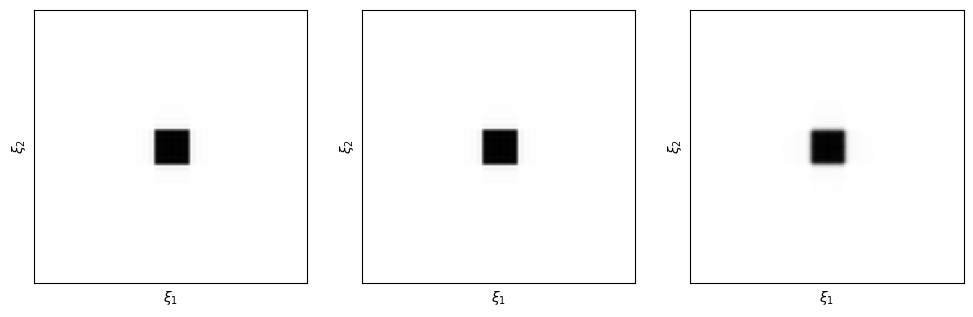

In [12]:
# Plot Figure 7 in the paper.
plt.figure(figsize=(12, 6))

plt.subplot(131)
helpers.plot_grayscale_image(rho_slepian_square, diverging=False, axis="\\xi")

plt.subplot(132)
helpers.plot_grayscale_image(rho_proxy_square, diverging=False, axis="\\xi")

plt.subplot(133)
helpers.plot_grayscale_image(rho_proxy_compl, diverging=False, axis="\\xi")

plt.show(block=False)

In [13]:
# Define a power spectral density (PSD) to use for evaluating the estimation
# performance of the tapers. This density is illustrated by Figure 8(a) in the
# paper.
psd_fun = (
    lambda xi1, xi2: np.exp(-80 * (xi1 - 0.20) ** 2 - 40 * (xi2 - 0.25) ** 2)
    + np.exp(-40 * (xi1 + 0.25) ** 2 - 80 * (xi2 + 0.25) ** 2)
    + 1.44 * np.exp(-80 * (xi1 - 0.10) ** 2 - 40 * (xi2 + 0.10) ** 2)
)

psd_true = psd_fun(*util.grid((N, N), shifted=True))

# Generate a single random image with the desired density.
signal = helpers.generate_field((N, N), 1, psd_fun=psd_fun, rng=rng, real=False)
signal = signal[0]

In [14]:
# Estimate the density using tensor tapers and proxy tapers (both from the
# square and disk complement domains).
psd_est_slepian_square = estimation.multitaper(signal, h_slepian_square, shifted=True)

psd_est_proxy_square = estimation.multitaper(signal, h_proxy_square, shifted=True)

psd_est_proxy_compl = estimation.multitaper(signal, h_proxy_compl, shifted=True)

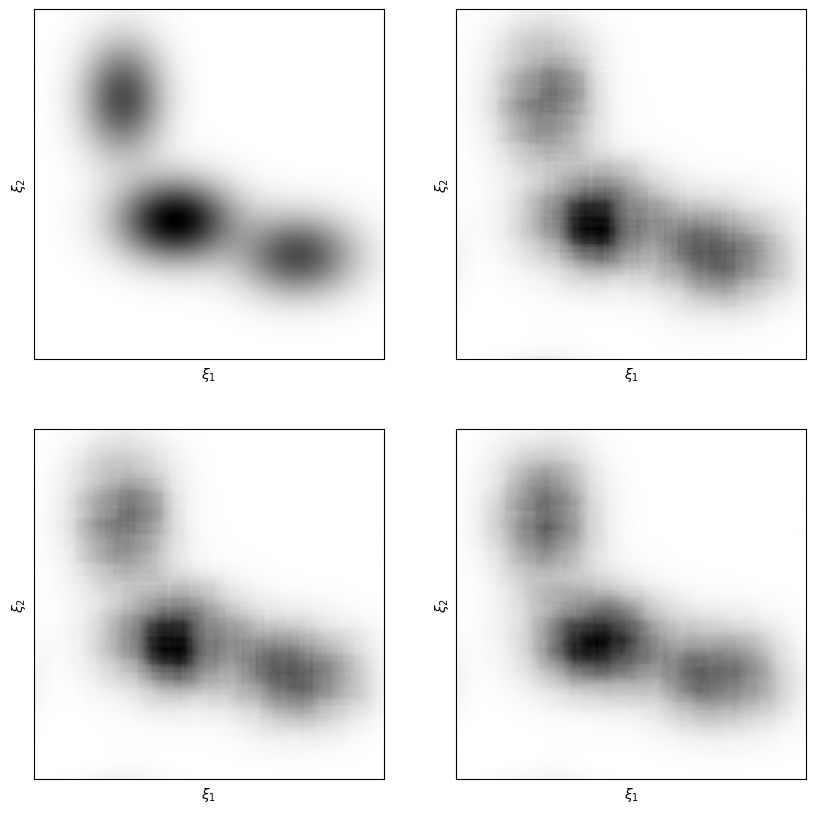

In [15]:
# Plot Figure 8 in the paper.
plt.figure(figsize=(10, 10))

plt.subplot(221)
helpers.plot_grayscale_image(psd_true, diverging=False, axis="\\xi")

plt.subplot(222)
helpers.plot_grayscale_image(psd_est_slepian_square, diverging=False, axis="\\xi")

plt.subplot(223)
helpers.plot_grayscale_image(psd_est_proxy_square, diverging=False, axis="\\xi")

plt.subplot(224)
helpers.plot_grayscale_image(psd_est_proxy_compl, diverging=False, axis="\\xi")

plt.show(block=False)

In [16]:
# Since we will need to calculate a few relative errors, it's easier to just
# define a function here.
def calc_relative_error(ref, est):
    error = np.sqrt(np.mean(np.abs(est - ref) ** 2))
    error /= np.sqrt(np.mean(np.abs(ref) ** 2))
    return error

In [17]:
# Calculate the error for each of the estimates as well as the deviation
# between the tensor taper estimate and the proxy taper estimate for the square
# mask.
error_slepian_square = calc_relative_error(psd_true, psd_est_slepian_square)
error_proxy_square = calc_relative_error(psd_true, psd_est_proxy_square)
error_proxy_compl = calc_relative_error(psd_true, psd_est_proxy_compl)

deviation = calc_relative_error(psd_est_slepian_square, psd_est_proxy_square)

In [18]:
# To verify the effect of convergence, we recalculate the proxy tapers on the
# square mask for a larger number of iterations. We use this to recalculate the
# density estimate and the corresponding deviation from the tensor taper
# estimate.
h_proxy_square_conv = tapers.proxy_tapers(mask_square, W, n_iter=72, K=K, rng=rng)

psd_est_proxy_square_conv = estimation.multitaper(
    signal, h_proxy_square_conv, shifted=True
)

deviation_conv = calc_relative_error(psd_est_slepian_square, psd_est_proxy_square_conv)

---

In [19]:
# Save data for figure generation.
helpers.save_image("density", psd_true)

helpers.save_image("mask1", rho_target)
helpers.save_image("mask2", mask_compl)
helpers.save_image("recmask2", mask_square)

helpers.save_image("rectap1", h_proxy_square[0])
helpers.save_image("rectap2", h_proxy_square[1])
helpers.save_image("rectap17", h_proxy_square[16])

helpers.save_image("recinten", rho_proxy_square)

helpers.save_image("recmt", psd_est_proxy_square)

helpers.save_image("tentap1", h_slepian_square[0])
helpers.save_image("tentap2", h_slepian_square[1])
helpers.save_image("tentap17", h_slepian_square[16])

helpers.save_image("teninten", rho_slepian_square)

helpers.save_image("tenmt", psd_est_slepian_square)

helpers.save_image("tap1", h_proxy_compl[0])
helpers.save_image("tap2", h_proxy_compl[1])
helpers.save_image("tap17", h_proxy_compl[16])

helpers.save_image("inten", rho_proxy_compl)

helpers.save_image("mt", psd_est_proxy_compl)

results = {
    "recerror": float(error_proxy_square),
    "tenerror": float(error_slepian_square),
    "deviation": float(deviation),
    "deviation_conv": float(deviation_conv),
}

helpers.save_dictionary("rectap", results)

results = {"error": float(error_proxy_compl)}

helpers.save_dictionary("tap", results)